# **Q1 Part b.**

Forecast avg time spent in the mall by a vehicle entering on a particular day, for the next 7 days.

# Processing and Visualizing Data

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#loading data
data = pd.read_csv("parkingLot (1).csv")

#converting timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['date'] = data['timestamp'].dt.date



data_grouped = data.groupby(['vehicle_no', 'date'])

#finding the time spent by each vehicle in the parking lot
time_spent = []
for (vehicle_no, date), vehicle_data in data_grouped:

    if len(vehicle_data) % 2 == 0:
        i = 0
        while i < len(vehicle_data) - 1:
            time_diff = vehicle_data["timestamp"].iloc[i + 1] - vehicle_data['timestamp'].iloc[i]
            time_spent.append({'date': date, 'time_spent': (time_diff.total_seconds())/60})
            i += 2
    
# Convert the result to a DataFrame
time_spent_df = pd.DataFrame(time_spent)

# Print the result
time_spent_df = time_spent_df.groupby('date').mean()

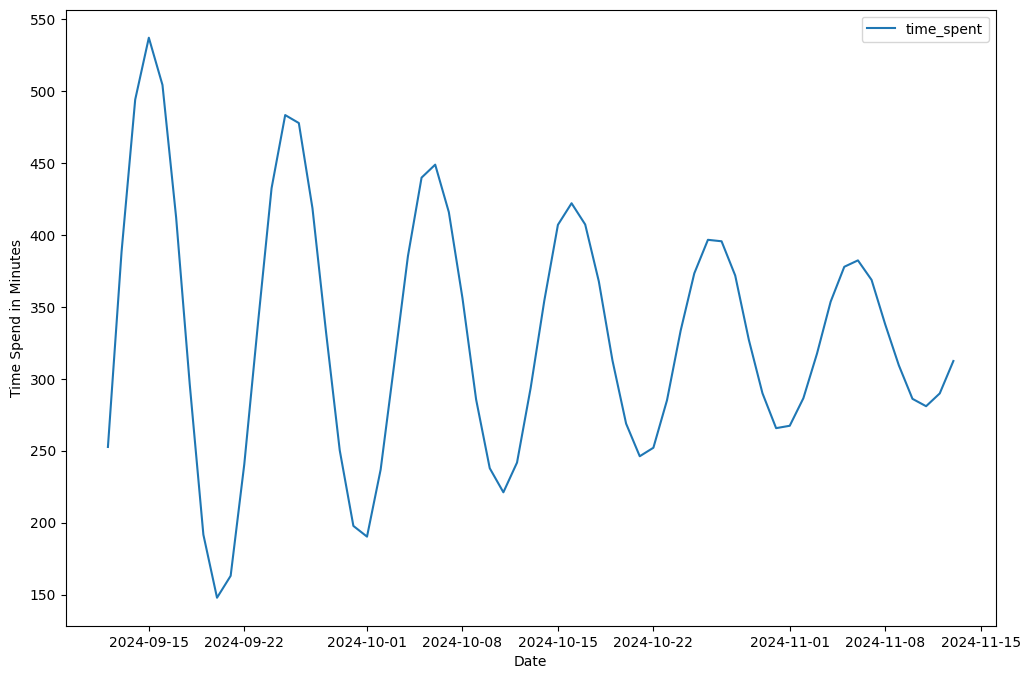

In [33]:
fig, ax = plt.subplots()

time_spent_df.plot(ax=ax, figsize=(12, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Time Spend in Minutes')
plt.show()

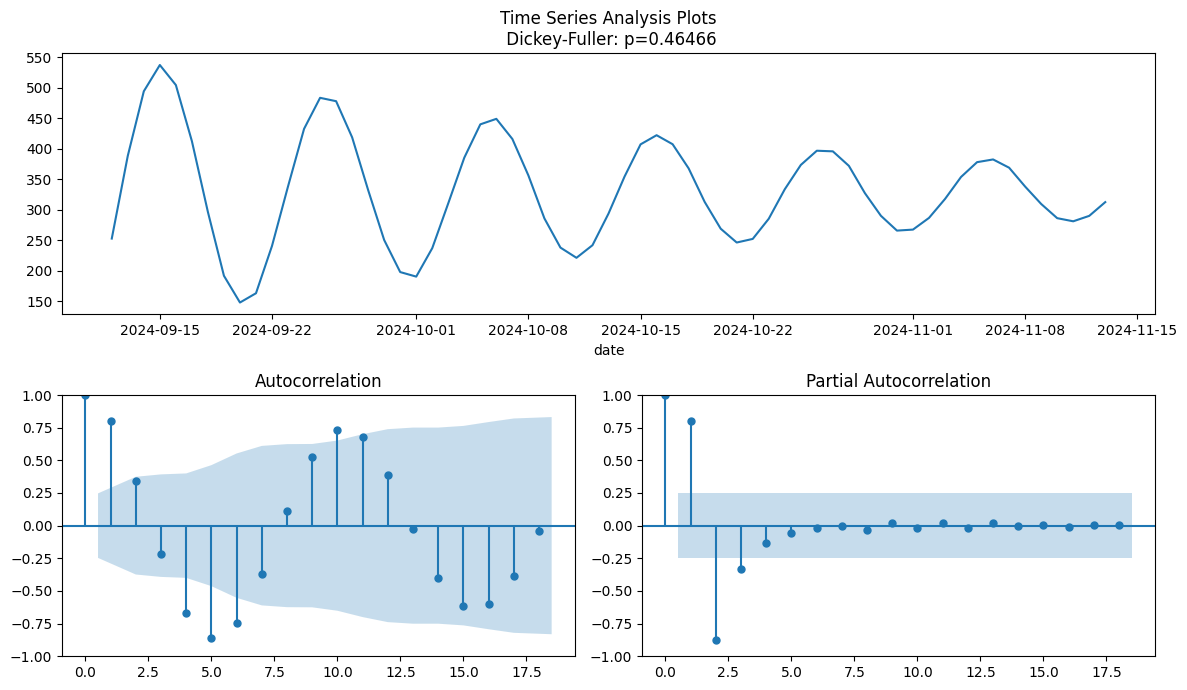

In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(time_spent_df['time_spent'])

# Test, Train Split

for (a) part of Q1 we only need to use data_entry

In [40]:
data_train = time_spent_df['time_spent'][:-7]
data_test = time_spent_df['time_spent'][-7:]

#  Fitting different model

1. Manual ARIMA Fitting
    - choosing p, d, q manually
2. Auto ARIMA Fittting
3. ETS

### Ignoring warnings

In [38]:
import warnings
warnings.filterwarnings("ignore")

### Manual Fitting

In [84]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_train, order=(3,0,3), seasonal_order=(3, 0, 1, 7)).fit()
#print(model_fit.summary())

### Auto Fitting

In [42]:
import pmdarima as pm
auto_arima = pm.auto_arima(data_train, stepwise=False, seasonal=True)
auto_arima

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

### ETS model

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit an Exponential Smoothing model
model_ETS = ExponentialSmoothing(data_train, seasonal='add', seasonal_periods=7).fit()

# Forecasting and Error Calculation


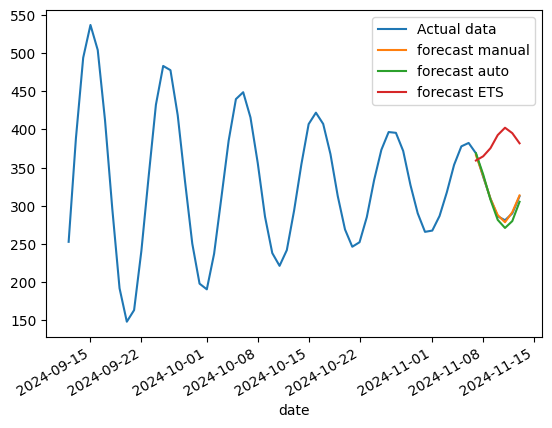

In [85]:
display_data = time_spent_df['time_spent'].copy()

fig, ax = plt.subplots()
display_data.plot(ax=ax, label='Actual data')
#ax.plot(display_data, label = 'Actual data')

forecast_test = model.forecast(steps = len(data_test))
forecast_test.plot(ax=ax, label='forecast manual')

forecast_test_auto = auto_arima.predict(n_periods=len(data_test))
forecast_test_auto.plot(ax=ax, label='forecast auto')

forecast_test_ETS = model_ETS.forecast(steps=len(data_test))
forecast_test_ETS.plot(ax=ax, label='forecast ETS')

plt.legend()
plt.show()

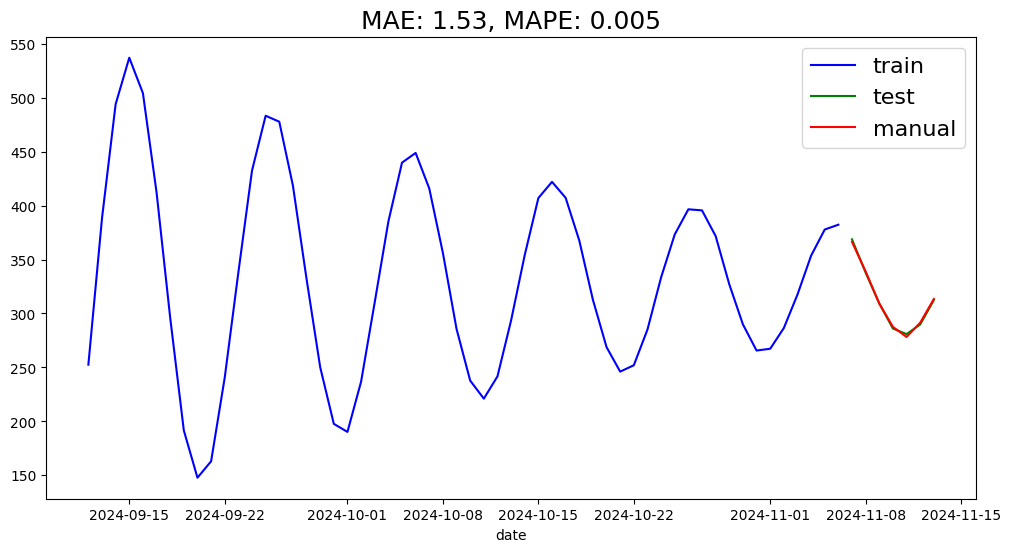

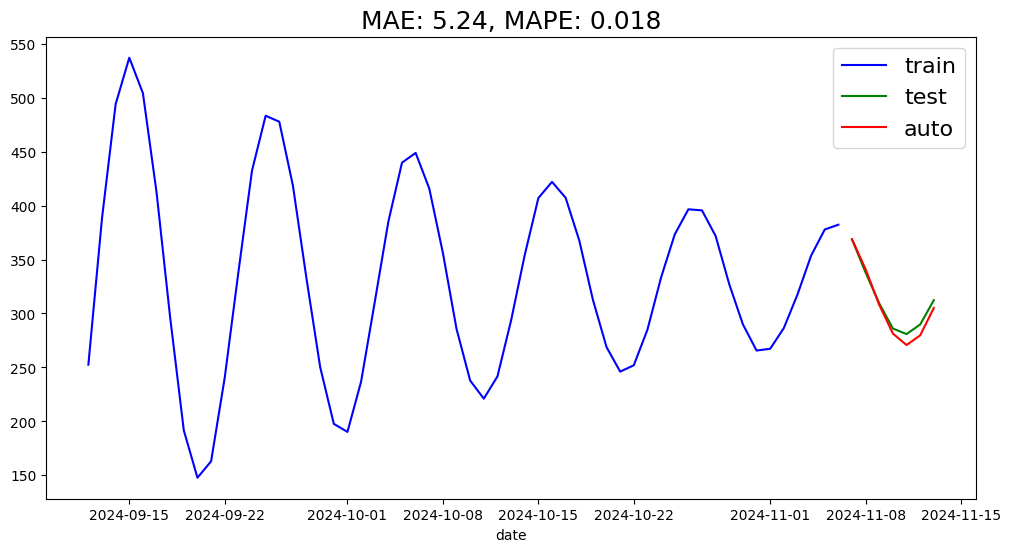

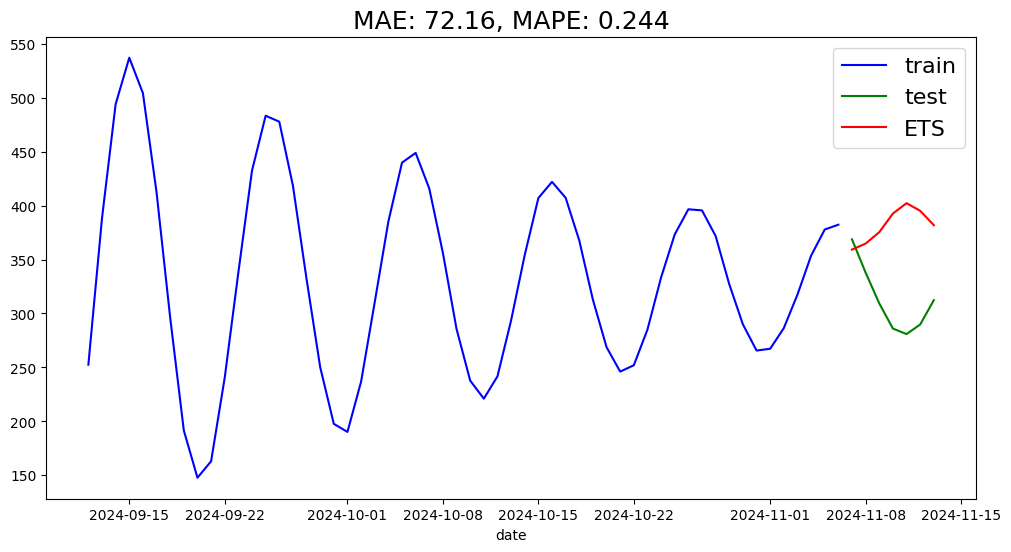

mae - manual: 1.5299078552051242
mape - manual: 0.004949827788846155
rmse - manual: 1.718408393064581


In [86]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(data_test, forecast_test)
mape = mean_absolute_percentage_error(data_test, forecast_test)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test))
def plot_forecast(series_train, series_test, forecast, forecast_int=None, label = 'forecast'):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label=label, color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

plot_forecast(data_train, data_test, forecast_test, label='manual')
plot_forecast(data_train, data_test, forecast_test_auto, label='auto')
plot_forecast(data_train, data_test, forecast_test_ETS, label = 'ETS')

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

In [54]:
mae = mean_absolute_error(data_test, forecast_test_auto)
mape = mean_absolute_percentage_error(data_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 5.240157081711694
mape - auto: 0.01774301603875495
rmse - auto: 6.428358598616741


In [55]:
mae = mean_absolute_error(data_test, forecast_test_ETS)
mape = mean_absolute_percentage_error(data_test, forecast_test_ETS)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_ETS))

print(f'mae - ETS: {mae}')
print(f'mape - ETS: {mape}')
print(f'rmse - ETS: {rmse}')

mae - ETS: 72.15849166286277
mape - ETS: 0.24417068791046717
rmse - ETS: 82.07879664899073
